# CLASS DATOS

In [1]:
import openpyxl
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

def most_common(lst):
    return max(set(lst), key=lst.count)

class Datos:
    def __init__(self, name):
        ## Abrir Excel con Datos
        file_train = name
        wb = openpyxl.load_workbook(file_train)
        self.sheet = wb.get_sheet_by_name('Sheet1')
        self.sheet = wb.active
        self.rows = self.sheet.max_row - 1

    def preprocess(self, train_, encoders_label):
        # Forma matriz para contener datos
        columns = self.sheet.max_column
        self.data_matrix = np.zeros(shape=(self.rows, columns))
        self.cols = columns
        self.target = np.zeros(shape=(self.rows, 1))
        
        # Columnas con datos categoricos, se deben pasar a labels numericos usando un LabelEncoder y luego a OneHotEncoder
        non_numerical_columns = [1, 4, 5, 8, 18, 19]  ##
        non_numerical_info = []
        clases = []
        clases_num_encode = []
        self.features_names = []
        empty_cell = self.sheet.cell(row=85, column=8).value  ## Ejemplo de celda vacia
        
        if train_:
            self.Label_Encoders = []
        else:
            lab_counter = 0
        
        for i in range(self.cols):
            j = 0 ## Contador para evitar primera fila
            column_i = []
            missing = []
            
            flag_non_numeric = False
            flag_append = True
            
            default_type = type(self.sheet.cell(row=2, column=i+1).value)
            #print default_type
            
            # Verificar si la columna es de datos no numericos
            if i in non_numerical_columns:
                flag_non_numeric = True

            for cellObj in self.sheet.columns[i]:
                if j > 0:   
                    cond1 = not cellObj.value
                    cond2 = cellObj.value == ""
                    cond3 = type(cellObj.value) != default_type
                    cond4 = i in [9,10,11,12,15] #Caracteristicas feas
                    if not cond4:
                        if cond1 or cond2 or cond3:
                            #print [cond1, cond2, cond3]
                            column_i.append(0)
                            missing.append(j-1)
                            #print "Reemplazando ", cellObj.value
                        else:
                            column_i.append(cellObj.value)
                    else:
                        column_i.append(cellObj.value)
                        

                else:
                    name = cellObj.value
                    if i>0:
                        if i != self.cols -1:
                            self.features_names.append(name)
                            print "Incorporando a matriz: " + name

                j += 1
               
            
            if flag_non_numeric:
                
                if train_:
                    le = preprocessing.LabelEncoder()
                    
                    if i == 8:
                        pseudo_column = list(column_i)
                        pseudo_column.append(u'CORONEL         ')
                        pseudo_column.append(u'FRESIA          ')
                        pseudo_column.append(u'SAN ESTEBAN     ')
                        pseudo_column.append(u'SAN PABLO       ')
                        pseudo_column.append(u'SANTA CRUZ      ')   
                        le.fit(pseudo_column)
                    else:
                        le.fit(column_i)
                    
                    self.Label_Encoders.append(le)
                else:
                    le = encoders_label[lab_counter]
                    lab_counter += 1
                
                clases.append(list(le.classes_))

                n_clases = len(le.classes_)
                ordered_clases = np.linspace(0, n_clases - 1, n_clases)
                inverse_ordered = le.inverse_transform(list(ordered_clases.astype(int)))
                print ordered_clases
                print "Labels: ", str(inverse_ordered)

                non_numerical_info.append(self.sheet.cell(row=1, column=i+1).value)

                # Encode de datos
                try:
                    column_i = le.transform(column_i)
                    ## Reemplazo de datos por moda
                    mode = most_common(column_i.tolist())
                    for index in missing:
                        column_i[index] = mode
                        
                except:
                    print "Imposible de transformar ", name
                

            else:
                ## Reemplazo de celdas vacias por el promedio
                try:        
                    mean = np.mean(column_i)
                    for index in missing:
                        column_i[index] = mean
                except:
                    print "Couldn't fill missing values of ", name
                
                
            if flag_append and i < self.cols - 1:
                self.data_matrix[:,i] = column_i
            else:
                print name + " No added"          
                
            if i == self.cols - 1:
                self.target = column_i
               
        
    def OneHotEncoding(self):
        non_numerical_columns = [1, 4, 5, 8, 18]
        examples = len(self.data_matrix[:,0])
        categorical = []
        
        
        for i in range(examples):
            example_categorical = []
            for index in non_numerical_columns:
                example_categorical.append(self.data_matrix[i][index])
            categorical.append(example_categorical)
                
        self.OHE = OneHotEncoder()
        self.OHE.fit(categorical)
        
        #print OHE.n_values_
        
        len_one_hot = sum(self.OHE.n_values_)
        
        self.data = []
        for i in range(examples):
            one_hot = self.OHE.transform(categorical[i]).toarray()
            row_data = []
            # Add numerical info
            for j in range(self.cols):
                if not j in non_numerical_columns:
                    row_data.append(self.data_matrix[i][j])
                   
            # Add categorical info
            output = self.add_categorical_one_hot(row_data, one_hot)            
            self.data.append(output)
                        
            
    def OneHotEncoding2(self):
        non_numerical_columns = [1, 4, 5, 8, 18]
        examples = len(self.data_matrix[:,0])
        categorical = []
        
        
        for i in range(examples):
            example_categorical = []
            for index in non_numerical_columns:
                example_categorical.append(self.data_matrix[i][index])
            categorical.append(example_categorical)
                
        self.OHE = OneHotEncoder()
        self.OHE.fit(categorical)
        
        #print OHE.n_values_
        hot = self.OHE.transform(categorical).toarray()
        
        
        len_one_hot = sum(self.OHE.n_values_)
        
        self.data = []
        for i in range(examples):
            one_hot = hot[i]
            row_data = []
            # Add numerical info
            for j in range(self.cols):
                if not j in non_numerical_columns:
                    row_data.append(self.data_matrix[i][j])
                   
            # Add categorical info
            output = self.add_categorical_one_hot(row_data, one_hot)            
            self.data.append(output)
            
        
    def add_categorical_one_hot(self, row_data, one_hot):
        output = row_data
        for binario in one_hot:
            output.append(binario)    
        return output
    
    def feat_names(self):
        return self.features_names
    
    def get_target(self):
        return self.target
    
    def get_matrix(self):
        return self.data_matrix
    
    def add_sum(self):
        self.cols += 1
        self.new_data_matrix = np.zeros(shape=(self.rows, self.cols))
        self.new_data_matrix[:,0:self.cols - 1] = self.data_matrix 
        
        for j in range(len(self.data_matrix[:,0])):
            a = self.data_matrix[j,9] + self.data_matrix[j,10] 
            b = self.data_matrix[j,11] + self.data_matrix[j,12]
            self.new_data_matrix[j, - 1] = (a + b)/4
        
        self.data_matrix = self.new_data_matrix
        self.features_names.append("Suma Creditos")
        
    def add_cuota_promedio(self):
        self.cols += 1
        self.new_data_matrix = np.zeros(shape=(self.rows, self.cols))
        self.new_data_matrix[:,0:self.cols - 1] = self.data_matrix 
        
        for j in range(len(self.data_matrix[:,0])):
            a = self.data_matrix[j,13]  
            b = self.data_matrix[j,17] 
            self.new_data_matrix[j, - 1] = a / b
        
        self.data_matrix = self.new_data_matrix
        self.features_names.append("Cuota Promedio")
        
                
train_datos = Datos('CREDITRISK_RAW.xlsx')
train_datos.preprocess(True, [])
data_matrix = train_datos.get_matrix()
train_datos.OneHotEncoding2()

Incorporando a matriz: GENERO
[ 0.  1.  2.]
Labels:  [u'0' u'F       ' u'M       ']
Incorporando a matriz: RENTA
Incorporando a matriz: EDAD
Incorporando a matriz: NIV_EDUC
[ 0.  1.  2.  3.  4.  5.  6.]
Labels:  [u'        ' u'0' u'BAS     ' u'EUN     ' u'MED     ' u'TEC     '
 u'UNV     ']
Incorporando a matriz: E_CIVIL
[ 0.  1.  2.  3.  4.]
Labels:  [u'0' u'CAS     ' u'SEP     ' u'SOL     ' u'VIU     ']
Incorporando a matriz: COD_OFI
Incorporando a matriz: COD_COM
Incorporando a matriz: CIUDAD
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.]
Labels:  [u'                ' u'0' u'ANCUD           ' u'ANGOL          

In [2]:
# Eliminar NaN values
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(data_matrix)

data_matrix = imp.transform(data_matrix)

In [3]:
## Calculo de caracteristicas

start_money_values = 9
finish_money_values = 12

"""
for i in range(12-9):
    for j in range(len(data_matrix[:,0])):
        sueldo = data_matrix[j,2]
        data_matrix[:,9+i] = data_matrix[:,9+i]/sueldo 
"""

train_datos.add_sum()
train_datos.add_cuota_promedio()
data_matrix = train_datos.get_matrix()



imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(data_matrix)

data_matrix = imp.transform(data_matrix)


In [4]:
def importances(clf, X, X_test):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    
    features_names = train_datos.feat_names()
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):

        #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        print str(f+1)+". "+ features_names[indices[f]] + ": "+str(importances[indices[f]])

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_test.shape[1]), importances[indices],
           color="r", align="center")
    #plt.xticks(range(X_test.shape[1]), indices)
    plt.xlim([-1, X_test.shape[1]])
    plt.show()

# CLASS HISTOGRAMAS

In [5]:
#Graficos en base a las caracteristicas más importantes según Random Forest

class Histogram:
    
    def __init__(self, data_matrix, target_matrix, feature_index, name):
        self.name = name
        self.index = feature_index
        rows = len(target_matrix)
        self.data = np.zeros(shape=(rows, 2))
        
        _columns = len(data_matrix[0,:])
        self.data[:,0] = data_matrix[:, self.index]
        #self.data[:,1] = data_matrix[:, _columns - 1]
        self.data[:,1] = target_matrix
        
        _N_datos = len(self.data[:,0])
        self.convert_data = np.zeros( shape = (_N_datos, 2))
    
        _Paga = 1;
        _NoPaga = 0;

        self.paga_hist = []
        self.no_paga_hist = []

        for i in range(_N_datos):
            if self.data[i,1] == _Paga:
                self.paga_hist.append( self.data[i,0])
            else:
                self.no_paga_hist.append( self.data[i,0])
                
        self.discrete = False


    def set_bins(self, init_range, final_range, nbins):
        self.bins = plt.linspace(init_range, final_range, nbins)
        self.nbins = nbins
        self.xlims = [init_range-0.5, final_range+0.5]
        print self.bins
        
    def is_discrete(self, discrete):
        init_range = 0
        final_range = discrete+0.5 
        nbins = discrete + 1
        self.bins = plt.linspace(init_range, final_range, nbins)
        self.nbins = discrete
        self.bar_l = plt.linspace(0,discrete-1, discrete)
        self.xlims = [-0.5, discrete+0.5]
        self.discrete = True

    def set_xlim(self, array):
        self.xlims = array
    
    def hist(self):
        _paid = self.paga_hist
        _no_paid = self.no_paga_hist
            
        x = [_paid, _no_paid]
        self.histo = plt.hist(x, self.bins)
        plt.clf()

        _to_bar_1 = self.histo[0][0]
        _to_bar_2 = self.histo[0][1]

        # Create the general blog and the "subplots" i.e. the bars
        f, ax1 = plt.subplots(1, figsize=(10,5))

        # Set the bar width
        bar_width = 0.75
        bar_width = (self.bins[self.nbins-1] - self.bins[0])/(self.nbins)

        # positions of the left bar-boundaries
        #bar_l = [(i+1)*2.5 for i in range(len(_to_bar_1))] #+ self.bins[0]
        bar_l = [self.bins[0] + (i+1)*(self.bins[self.nbins-1] - self.bins[0])/(self.nbins) for i in range(len(_to_bar_1))]
  
        if (self.discrete == True):
            bar_width = 1.0
            bar_l = self.bar_l
        
        
  
    
        # positions of the x-axis ticks (center of the bars as bar labels)
        tick_pos = [i+(bar_width/2) for i in bar_l] #+ self.bins[0] 

        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                # using the pre_score data
                _to_bar_1,
                # set the width
                width=bar_width,
                # with the label pre score
                label='Paga',
                # with alpha 0.5
                alpha=0.5,
                # with color
                color='#808000')

        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                # using the mid_score data
                _to_bar_2,
                # set the width
                width=bar_width,
                # with pre_score on the bottom
                bottom=_to_bar_1,
                # with the label mid score
                label='No paga',
                # with alpha 0.5
                alpha=0.5,
                # with color
                color='#4b0082')
        

        
        # Set the label and legends
        ax1.set_ylabel("Cantidad")
        ax1.set_xlabel(self.name)
        ax1.set_xlim(self.xlims)
        plt.legend(loc='upper left')

        # Set a buffer around the edge
        #plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
        
class double_graph:
    
    def __init__(self, index_1, index_2, target_matrix):
        self.index = index_1
        self.index2 = index_2
        rows = len(target_matrix)
        self.data = np.zeros(shape=(rows, 3))
        
        _columns = len(data_matrix[0,:])
        self.data[:,0] = data_matrix[:, self.index]
        self.data[:,1] = data_matrix[:, _columns - 1]
        self.data[:,2] = data_matrix[:, self.index2]
        
        _N_datos = len(self.data[:,0])
        self.convert_data = np.zeros( shape = (_N_datos, 2))
    
        _Paga = 1;
        _NoPaga = 0;

        self.feature_1_paid = []
        self.feature_2_paid = []
        
        self.feature_1_nopaid = []
        self.feature_2_nopaid = []
        
        for i in range(_N_datos):
            if self.data[i,1] == _Paga:
                self.feature_1_paid.append(self.data[i,0]) 
                self.feature_2_paid.append(self.data[i,2])
            else:
                self.feature_1_nopaid.append(self.data[i,0])
                self.feature_2_nopaid.append(self.data[i,2]) 
    
    def plot(self):
        plt.figure()
        
        p_1_x = self.feature_1_paid 
        p_1_y = self.feature_2_paid 
        
        p_2_x = self.feature_1_nopaid 
        p_2_y = self.feature_2_nopaid 
        
        p1, = plt.plot(p_1_x, p_1_y, 'o', color='b', alpha = 0.4)
        p2, = plt.plot(p_2_x, p_2_y, 'o', color='y', alpha = 0.4) ##g^

        x1 = min(p_1_x)
        x2 = min(p_2_x)
        x3 = min([x1,x2])
        
        y1 = min(p_1_y)
        y2 = min(p_2_y)
        y3 = min([y1, y2])
        
        x11 = max(p_1_x)
        x22 = max(p_2_x)
        x33 = max([x11,x22])
        
        y11 = max(p_1_y)
        y22 = max(p_2_y)
        y33 = max([y11, y22])
        
        x_ = x3 - (x33 - x3)*0.10
        x_up = x33 + (x33 - x3)*0.10
        y_ = y3 - (y33 - y3)*0.10
        y_up = y33 + (y33 - y3)*0.10
        
        print [x_, x_up, y_, y_up]
        
        plt.axis([x_, x_up, y_, y_up])
        plt.xlabel(features_names[self.index-1])
        plt.ylabel(features_names[self.index2-1])

        
        
        plt.legend([ p1, p2], ["Paga" ,"No Paga"])


# GRAFICOS HISTOGRAMAS

In [6]:
plot_hists = False

if plot_hists:

    ## EDAD ##
    age_hist = Histogram(data_matrix, Y, 3, "Edad")
    age_hist.set_bins(20,65, 45) ## DE 20 a 60 años, 20 intervalos
    age_hist.hist()

    ## RENTA ##
    rent_hist = Histogram(data_matrix, Y,  2, "Renta (Pesos)")
    rent_hist.set_bins(40000, 2e6, 20)
    rent_hist.hist()

    ## GENERO ##
    genre_hist = Histogram(data_matrix, Y, 1, "Genero")
    #rent_hist.set_bins(50000, 1e6, 10)
    genre_hist.is_discrete(2)
    genre_hist.hist()

    ## NIVEL EDUCACIONAL ##
    niv_ED_hist = Histogram(data_matrix,Y, 4, "Nivel Educacional")
    #rent_hist.set_bins(50000, 1e6, 10)
    niv_ED_hist.is_discrete(6)
    niv_ED_hist.set_xlim([2.5,6.5])
    niv_ED_hist.hist()

    ## CANTIDAD DE MESES INACTIVO ##
    cod_com_hist = Histogram(data_matrix, Y,  16, "Cantidad de meses inactivo")
    #cod_com_hist.set_bins(0, 3, 3)
    cod_com_hist.is_discrete(3)
    cod_com_hist.hist()

    ## COD_COM ##
    cod_com_hist = Histogram(data_matrix, Y,  7, "Codigo de Comuna")
    cod_com_hist.set_bins(0, 300, 300)
    cod_com_hist.hist()

    graph = double_graph(4,1, Y)
    graph.plot()

# RANDOM FOREST

In [17]:
## Random Forest
%matplotlib inline
import matplotlib.pylab as plt

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


long_data_array = True

if long_data_array:   
    data_array = np.asarray(train_datos.data)
    
    delete_nans = Imputer(missing_values='NaN', strategy='mean', axis=0)
    delete_nans.fit(data_array)
    data_array = delete_nans.transform(data_array)
    
    N_features = len(np.asarray(train_datos.data)[0,:]) 
    X = data_array[:,1:N_features]
    Y = train_datos.get_target()
    
else:
    N_features = (len(data_matrix[0,:]) - 1) # Se resta ID y Label, PAGA o NO PAGA
    X = data_matrix[:,1:N_features]
    Y = train_datos.get_target()




X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.6, random_state = True)


RF = RandomForestClassifier(n_estimators=500, max_depth=None, bootstrap = True, n_jobs = -1)
RF.fit(X_train, Y_train)
Y_pred = RF.predict_proba(X_test)


#importances(clf, X, X_test)

        
        




from time import time
from sklearn import metrics
t0 = time()
pred = RF.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

score = metrics.accuracy_score(Y_test, pred)
print "Score: ", score

test time:  0.638s
Score:  0.93137254902


# ADABOOST

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(adaboost, X, Y)
print scores.mean()                             

adaboost.fit(X_train, Y_train)


0.931998768094


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

# SVM

In [73]:
from sklearn import svm
from sklearn import preprocessing

X_scaled = preprocessing.scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, train_size=0.6, random_state = True)

clf = svm.SVC(kernel='rbf',degree=3, C = 18.0, gamma = 0.06)
clf.fit(X_train, Y_train)

pred = clf.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

score = metrics.accuracy_score(Y_test, pred)
print score



test time:  2764.879s
0.895424836601


# NEURAL NET 

In [10]:
from sklearn.neural_network import MLPClassifier

X_scaled = preprocessing.scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, train_size=0.5, random_state = True)

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(70, 20), 
                   random_state=1)
NN.fit(X_train, Y_train)

pred = NN.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

score = metrics.accuracy_score(Y_test, pred)
print score

test time:  3.547s
0.895379250218


# ANALISIS DE SENSIBILIDAD

In [75]:
def iterator(iterations):
    scores_ = []
    parameters = []
    for i in range(iterations):
        parameter = (10**(i-3))
        parameters.append(parameter)
        model = svm.SVC(kernel='rbf',degree=3, C = parameter, gamma = 0.06)
        model.fit(X_train, Y_train)
        #Y_pred = model.predict_proba(X_test)
        pred = model.predict(X_test) 
        score = metrics.accuracy_score(Y_test, pred)
        scores_.append(score)
    
    return [scores_, parameters]

        
def promediador(n_models, iterations):
    means = []
    for i in range(n_models):
        [score_list, parameters] = iterator(iterations)
        means.append(score_list)
    
    
    new_means = np.asarray(means)
    print new_means
    output_means = []
    for i in range(iterations):
        output_means.append(np.mean(new_means[:,i]))
    return [parameters, output_means]
        
parametric_score = promediador(3, 6)

print parametric_score

[[ 0.46949891  0.82026144  0.86492375  0.89542484  0.89433551  0.88997821]
 [ 0.46949891  0.82026144  0.86492375  0.89542484  0.89433551  0.88997821]
 [ 0.46949891  0.82026144  0.86492375  0.89542484  0.89433551  0.88997821]]
[[0.001, 0.01, 0.1, 1, 10, 100], [0.46949891067538124, 0.82026143790849682, 0.8649237472766883, 0.89542483660130723, 0.89433551198257077, 0.8899782135076254]]


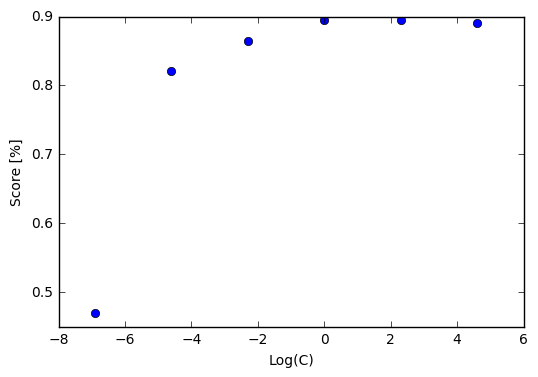

In [76]:
x_ = np.log(parametric_score[0])
y_ = parametric_score[1]
plt.plot(x_ , y_ , 'o')

#plt.xlim([-12, 1])
#plt.ylim([0.7, 1])
plt.xlabel("Log(C)")
plt.ylabel("Score [%]")

# SCORE DATOS

In [11]:
class Data_Evaluate(Datos):
    
    #def __init__(self, name):
    #    file_train = "COPIA.xlsx"
    #    wb = openpyxl.load_workbook(file_train)
    #    self.sheet = wb.get_sheet_by_name('Sheet1')
    #    self.sheet = wb.active
    #    #self.sheet.cell(row=2, column=20).value = "THIS IS SPARTA" 
    
    def OneHotEncoding_SCORE(self, encoder):
        non_numerical_columns = [1, 4, 5, 8, 18]
        examples = len(self.data_matrix[:,0])
        categorical = []
        
        
        for i in range(examples):
            example_categorical = []
            for index in non_numerical_columns:
                example_categorical.append(self.data_matrix[i][index])
            categorical.append(example_categorical)
                

        hot = encoder.transform(categorical).toarray()
        
        len_one_hot = sum(encoder.n_values_)
        
        self.data = []
        for i in range(examples):
            one_hot = hot[i]
            row_data = []
            # Add numerical info
            for j in range(self.cols):
                if not j in non_numerical_columns:
                    row_data.append(self.data_matrix[i][j])
                   
            # Add categorical info
            output = self.add_categorical_one_hot(row_data, one_hot)            
            self.data.append(output)


    def evaluate(self, encoder, model):
        self.OneHotEncoding_SCORE(encoder)
        self.data_score = np.asarray(self.data)
        
        imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
        imp.fit(self.data_score)
        self.data_score = imp.transform(self.data_score)
        
        print "Largo", len(self.data_score[1:0])
        
        self.prediction = model.predict(self.data_score[:,1:])        
        
        return self.prediction
   
    def write_excel(self):
        file_train = "COPIA.xlsx"
        wb = openpyxl.load_workbook(file_train)
        self.sheet = wb.get_sheet_by_name('Sheet1')
        self.sheet = wb.active
        write_row = 2
        for score_pred in self.prediction:
            if score_pred == 1:  ## Paga
                self.sheet.cell(row=write_row, column=20).value = "PAGA"
            else:
                self.sheet.cell(row=write_row, column=20).value = "NO PAGA"
            write_row += 1
        
        wb.save('salida.xlsx')
                
            


In [12]:
#train_datos = Datos('CREDITRISK_SCORE.xlsx')
#data_matrix = train_datos.get_matrix()
#train_datos.OneHotEncoding()

score_datos = Data_Evaluate('CREDITRISK_SCORE.xlsx')
score_datos.preprocess(False, train_datos.Label_Encoders)

#score_datos.evaluate(train_datos.OHE, modelo)

modelo = RF
score_prediction = score_datos.evaluate(train_datos.OHE, modelo)

score_datos.write_excel()




Incorporando a matriz: GENERO
[ 0.  1.  2.]
Labels:  [u'0' u'F       ' u'M       ']
Incorporando a matriz: RENTA
Incorporando a matriz: EDAD
Incorporando a matriz: NIV_EDUC
[ 0.  1.  2.  3.  4.  5.  6.]
Labels:  [u'        ' u'0' u'BAS     ' u'EUN     ' u'MED     ' u'TEC     '
 u'UNV     ']
Incorporando a matriz: E_CIVIL
[ 0.  1.  2.  3.  4.]
Labels:  [u'0' u'CAS     ' u'SEP     ' u'SOL     ' u'VIU     ']
Incorporando a matriz: COD_OFI
Incorporando a matriz: COD_COM
Incorporando a matriz: CIUDAD
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.]
Labels:  [u'                ' u'0' u'ANCUD           ' u'ANGOL          

C:\Users\Nico\Anaconda2\lib\site-packages\numpy\lib\arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
